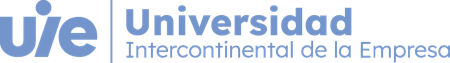

**G24GXX3.10X. Aprendizaje Automático**

**Profesor: Borja González Seoane**

**Realización de la práctica: Víctor Vega Sobral**
Curso 2024-25

# PL06. Clustering with DBSCAN

In this practice we will implement and test a _from scratch_ version of the DBSCAN clustering algorithm. We will use synthetically generated data to verify the algorithm's functionality, taking advantage of testing the use of *KMeans* on the same data beforehand, for comparison. **This _notebook_ will also serve to break down the DBSCAN algorithm, seen in class slides, using Markdown cells and comments to compose a step-by-step guide and pseudocode.**


## Clustering with DBSCAN

<!-- Text in red -->
<font color='red'>
#TODO: Add here a description of the DBSCAN algorithm using your own words...
</font>

DBSCAN is a clustering algorithm that classifies data based on the density of points. It identifies dense regions, i.e. clusters, and isolated points, referred to as noise.
To compose the algorithm, it is necessary to know the following definitions:
1. **Core point**: is a point with at least a minimum number of neighbors (**minPts**) within a distance **epsilon**.

2. **Direct neighborhood:** are all points that are within the distance **epsilon** to a point. 

3. **Cluster**: group of points connected by direct neighborhood or through other core points.
4. **Noise**: points that are outside the direct neighborhood of any cluster, known as noise.




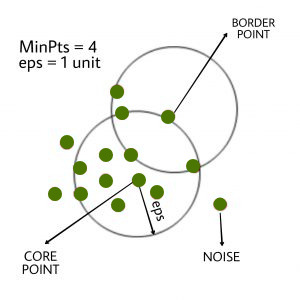

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

## Creation of concentric circles with noise points

Implement an auxiliary function that generates a circumference of noise points. Parameterize it with `n` and `r` for the number of points and the radius of the circumference, respectively. This function will be used for generating synthetic data to confront *K-means* and DBSCAN.

In [ ]:
def points_on_circumferences(n: int, r: int) -> np.ndarray:
    """
    Generates `n` points on a circumference of radius `r` with Gaussian noise.
    
    Args:
        n: Number of points to generate
        r: Radius of the circumference
    
    Returns:
        Numpy array of shape (n,2) with the coordinates of the points
    """
    # Generate equidistant angles
    angles = np.linspace(0, 2*np.pi, n)
    
    # Calculate x,y coordinates
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    
    # Add Gaussian noise
    noise = np.random.normal(0, 0.1, (n,2))
    
    # Combine coordinates and noise
    points = np.column_stack((x,y)) + noise
    
    return points


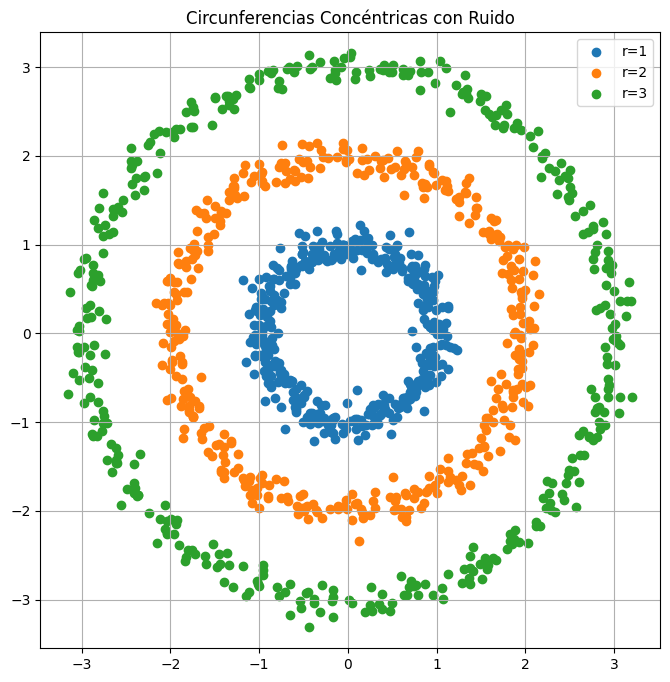

In [ ]:
# Create 3 concentric circumferences
n_points = 400
radius1, radius2, radius3 = 1, 2, 3

points1 = points_on_circumferences(n_points, radius1)
points2 = points_on_circumferences(n_points, radius2)
points3 = points_on_circumferences(n_points, radius3)

# Visualize the results
plt.figure(figsize=(8, 8))
plt.scatter(points1[:, 0], points1[:, 1], label='r=1')
plt.scatter(points2[:, 0], points2[:, 1], label='r=2')
plt.scatter(points3[:, 0], points3[:, 1], label='r=3')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.title('Concentric Circumferences with Noise')
plt.show()

## Use *K-means* _scratch_ or Scikit-Learn to attempt clustering the generated data

What happens? Is *K-means* useful for this type of data?

In this case, the data is grouped in concentric circles. However, **K-means** is not able to correctly group these patterns. This happens because K-means is an algorithm that **is not designed for datasets with arbitrary shapes**. Mathematically, K-means assumes that clusters have a convex and separated shape, while concentric circles do not satisfy this assumption, causing the algorithm to fail when correctly identifying the dense zones corresponding to the clusters.


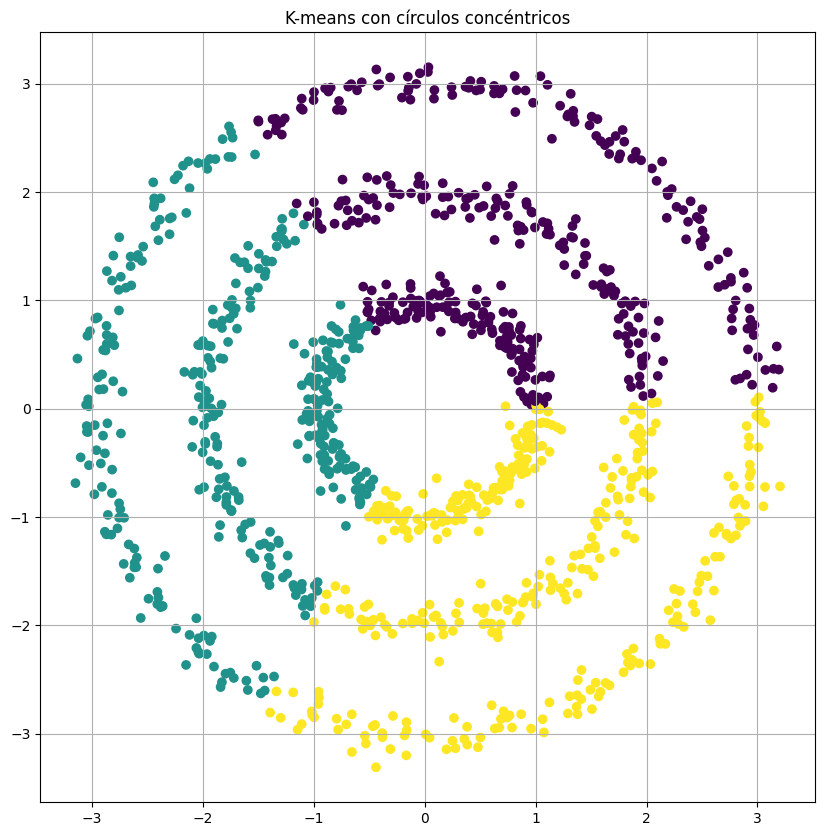

In [ ]:
# Use kmeans on the data and see the segmentation


K = 3

# Create K-Means instance with N clusters
kmeans = KMeans(n_clusters=K, random_state=42)

# Combine all points
X = np.vstack((points1, points2, points3))

# Train the model with the concentric circles data
kmeans.fit(X)

# Get predictions
y_pred = kmeans.predict(X)

# Visualize the results
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis')

plt.title('K-means with concentric circles')

plt.grid(True)
plt.show()


## Initial test with Scikit-Learn DBSCAN

To know what to expect when implementing DBSCAN _scratch_.

array([0, 1], dtype=int64)

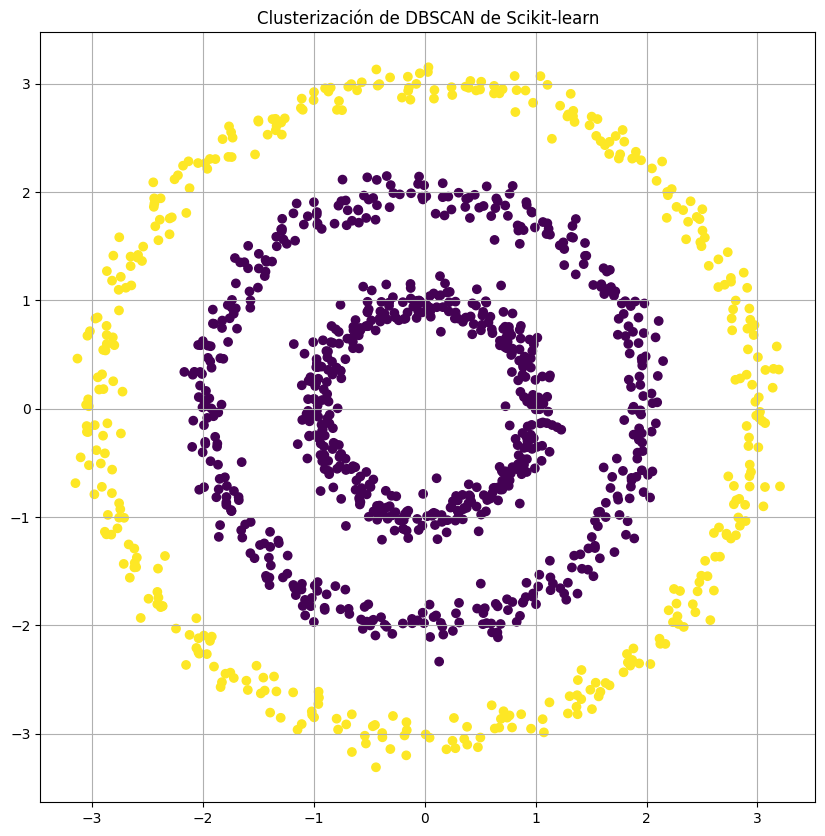

In [ ]:
# Train the DBSCAN instance

dbscan_nk = DBSCAN()

dbscan_nk.fit(X)


# Visualize how many clusters have been found

cluster_labels_sk = dbscan_nk.labels_
display(np.unique(cluster_labels_sk))

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_sk, cmap='viridis')

plt.title('Scikit-learn DBSCAN clustering')

plt.grid(True)
plt.show()

# DBSCAN algorithm pseudocode

1. **Initialization**:
    - Set parameters `eps` (neighborhood radius) and `min_samples` (minimum points for density).
    - Label all points as `0`:
        - `0`: Not visited.
        - `-1`: Noise.
        - `>0`: Cluster ID.

2. **Algorithm execution**:
    1. For each point \( P \) in the dataset:
        1. If \( P \) has already been visited, move to the next point.
        2. Get neighbors of \( P \):
            - Calculate the Euclidean distance from \( P \) to all points.
            - Select points whose distance is less than or equal to `eps`.
        3. If the number of neighbors is less than `min_samples`:
            - Label \( P \) as `-1` (noise).
        4. If the number of neighbors is greater than or equal to `min_samples`:
            - Assign a new cluster ID to \( P \).
            - Expand the cluster from \( P \).

3. **Cluster expansion**:
    1. While there are points in the cluster neighborhood:
        - For each neighbor \( N \):
            1. If \( N \) is labeled as noise:
                - Reassign \( N \) to the current cluster.
            2. If \( N \) has not been visited:
                - Assign \( N \) to the current cluster.
                - Get neighbors of \( N \):
                    - If \( N \) has enough neighbors, add them to the current neighbor list.
        - Continue expanding until there are no more points in the neighborhood.

4. **Completion**:
    - Increment the cluster ID and continue with the next point.

5. **Output**:
    - Return point labels (`self._labels`), where:
        - \( -1 \): Noise.
        - \( 1, 2, $\dots$, k \): Detected clusters.


In [ ]:
class DBSCANScratch:
    def __init__(self, eps=0.3, min_samples=10):
        self.eps = eps
        self.min_samples = min_samples
        self._labels = None

    def _find_neighbors(self, X: np.ndarray, point_idx: int) -> np.ndarray:
        """Finds neighbors within the eps radius"""
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= self.eps)[0]

    def fit(self, X: np.ndarray):
        """Fits the DBSCAN model to the data"""
        n_samples = X.shape[0]
        self._labels = np.zeros(n_samples)  # 0: not visited, -1: noise, >0: cluster ID
        
        cluster_id = 1
        for point_idx in range(n_samples):
            # If the point has already been visited, move to the next
            if self._labels[point_idx] != 0:  # Fixed here
                continue
            
            # Find neighbors of the current point
            neighbors = self._find_neighbors(X, point_idx)
            
            # If there aren't enough neighbors, mark as noise
            if len(neighbors) < self.min_samples:
                self._labels[point_idx] = -1
                continue
            
            # Expand the current cluster
            self._labels[point_idx] = cluster_id
            i = 0
            while i < len(neighbors):
                neighbor = neighbors[i]
                
                if self._labels[neighbor] == -1:
                    self._labels[neighbor] = cluster_id
                
                elif self._labels[neighbor] == 0:
                    self._labels[neighbor] = cluster_id
                    new_neighbors = self._find_neighbors(X, neighbor)
                    
                    if len(new_neighbors) >= self.min_samples:
                        neighbors = np.concatenate([neighbors, new_neighbors])
                
                i += 1
            
            cluster_id += 1
        
        return self



## Testing the DBSCAN implementation

array([1., 2., 3.])

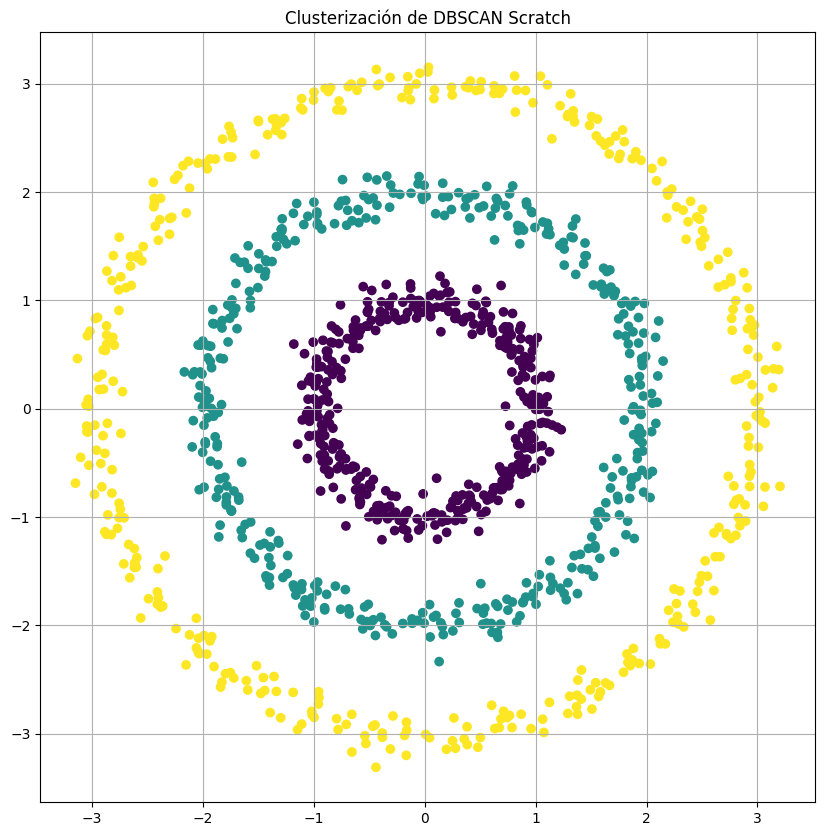

In [ ]:
# Test the corrected algorithm
dbscan_scratch = DBSCANScratch(eps=0.4, min_samples=8)
dbscan_scratch.fit(X)

cluster_labels_scratch = dbscan_scratch._labels
display(np.unique(cluster_labels_scratch))

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_scratch, cmap='viridis')
plt.title('DBSCAN Scratch clustering')
plt.grid(True)
plt.show()